In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, EstimatorV2 as Estimator
import numpy as np
import itertools
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from collections import Counter

### Problem

$$\text{Maximize } z = 10x_1 + 5x_2$$
#### Restrictions

Year 1:  $ 3x_1 + 2x_2 \leq 5$

Year 2:  $ 2x_1 + 4x_2 \leq 5$

In [3]:
def create_project_selection_qubo(alpha):
    mu = [10, 5]
    constraints = [[3, 2], [2, 4]]
    rhs = [5, 5]  

    # Initialize empty QUBO model
    qp = QuadraticProgram('Project_Selection_QUBO')

    for i in range(len(mu)):
        qp.binary_var(name=f'x{i}')

    qp.minimize()

    # original objective function
    for i in range(len(mu)):
        qp.objective.linear[f'x{i}'] = -mu[i]

    for coeffs, limit in zip(constraints, rhs):
        # Constant term from penalty expansion 
        qp.objective.constant += alpha * (limit ** 2) 
        # Linear terms from penalty expansion [(-2α * b * c_i * x_i)]
        for i in range(len(mu)):
            qp.objective.linear[f'x{i}'] += -2 * alpha * limit * coeffs[i]
            # All quadratic cross terms [(α * c_i * c_j * x_i * x_j)]
            for j in range(len(mu)):
                qp.objective.quadratic[f'x{i}', f'x{j}'] += alpha * coeffs[i] * coeffs[j]

    return qp

In [4]:
def hamiltonian_offset(problem):
    return problem.to_ising()

def create_circuit(hamiltonian, p, optmization_level, backend):
    circuit = QAOAAnsatz(cost_operator=hamiltonian, reps=p)
    circuit.measure_all()

    pm = generate_preset_pass_manager(optimization_level=optmization_level, backend=backend)

    return pm.run(circuit)

def cost_function_estimator(params, ansatz, hamiltonian, estimator):
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    return cost

backend = AerSimulator()

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

def run_experiment(repetitions, num_qb, p, shots_estimator, shots_sampler, optimization_level, hamiltonian):
    circuit = create_circuit(hamiltonian, p, optimization_level, backend)

    estimator = Estimator(mode=backend)
    estimator.options.default_shots = shots_estimator

    sampler  = Sampler(mode=backend)
    sampler.options.default_shots = shots_sampler

    most_likely_bitstrings = []
    for _ in range(repetitions):
        innitial_gamma = 2 * np.pi * np.random.rand()
        innitial_beta = 2 * np.pi * np.random.rand()
        init_params = [val for _ in range(p) for val in (innitial_gamma, innitial_beta)]

        result = minimize(cost_function_estimator, init_params, args=(circuit, hamiltonian, estimator), method="COBYLA", tol=1e-2)

        parameterized_circuit = circuit.assign_parameters(result.x)
        pub = (parameterized_circuit, )
        job = sampler.run([pub])
        counts_int = job.result()[0].data.meas.get_int_counts()
        counts_bin = job.result()[0].data.meas.get_counts()
        shots = sum(counts_int.values())
        final_distribution_int = {key: val/shots for key, val in counts_int.items()}
        final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

        keys = list(final_distribution_int.keys())
        values = list(final_distribution_int.values())
        most_likely = keys[np.argmax(np.abs(values))]
        most_likely_bitstring = to_bitstring(most_likely, num_qb)
        most_likely_bitstring.reverse()
        most_likely_bitstrings.append(most_likely_bitstring)

    
    return most_likely_bitstrings

In [5]:
def run_experiment_all_values(repetitions, num_qb, p, shots_estimator, shots_sampler, optimization_level, hamiltonian):
    circuit = create_circuit(hamiltonian, p, optimization_level, backend)

    estimator = Estimator(mode=backend)
    estimator.options.default_shots = shots_estimator

    sampler  = Sampler(mode=backend)
    sampler.options.default_shots = shots_sampler

    all_bitstrings = []
    for _ in range(repetitions):
        innitial_gamma = 2 * np.pi * np.random.rand()
        innitial_beta = 2 * np.pi * np.random.rand()
        init_params = [val for _ in range(p) for val in (innitial_gamma, innitial_beta)]

        result = minimize(cost_function_estimator, init_params, args=(circuit, hamiltonian, estimator), method="COBYLA", tol=1e-2)

        parameterized_circuit = circuit.assign_parameters(result.x)
        pub = (parameterized_circuit, )
        job = sampler.run([pub])
        counts_int = job.result()[0].data.meas.get_int_counts()
        counts_bin = job.result()[0].data.meas.get_counts()
        shots = sum(counts_int.values())

        for bitstring_int, count in counts_int.items():
            bitstring = to_bitstring(bitstring_int, num_qb)
            bitstring.reverse()
            all_bitstrings.extend([bitstring] * count)

    return all_bitstrings

In [6]:
def plot_graph_bitstrings_results(results, top=None):
    bitstring_results = ["".join(map(str, sublist)) for sublist in results]
    counts = Counter(bitstring_results)

    if top is not None:
        selected_bitstrings = list(counts.keys())[:top]
    else:
        selected_bitstrings = list(counts.keys())

    occurrences = [counts[bitstring] for bitstring in selected_bitstrings]

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title("Results")
    plt.xlabel("Bitstrings")
    plt.ylabel("Occurrences")

    bars = ax.bar(selected_bitstrings, occurrences, color="tab:grey")

    if selected_bitstrings:
        most_common_bitstring = max(selected_bitstrings, key=lambda b: counts[b])
        for i, bitstring in enumerate(selected_bitstrings):
            if bitstring == most_common_bitstring:
                bars[i].set_color("tab:purple")

    plt.tight_layout()
    plt.show()

In [7]:
alpha = 1
qubo_model_p = create_project_selection_qubo(alpha)

print(qubo_model_p.prettyprint())


Problem name: Project_Selection_QUBO

Minimize
  13*x0^2 + 28*x0*x1 + 20*x1^2 - 60*x0 - 65*x1 + 50

Subject to
  No constraints

  Binary variables (2)
    x0 x1



In [8]:
all_combinations = list(itertools.product([0, 1], repeat=2))

for combination in all_combinations:
    combination_list = list(combination)  
    value = qubo_model_p.objective.evaluate(combination_list)
    print(f"{combination_list} → Return: {value}")

[0, 0] → Return: 50.0
[0, 1] → Return: 5.0
[1, 0] → Return: 3.0
[1, 1] → Return: -14.0


In [8]:
hamiltonian, offset = hamiltonian_offset(qubo_model_p)
print(hamiltonian, offset)

SparsePauliOp(['IZ', 'ZI', 'ZZ'],
              coeffs=[16.5+0.j, 15.5+0.j,  7. +0.j]) 11.0


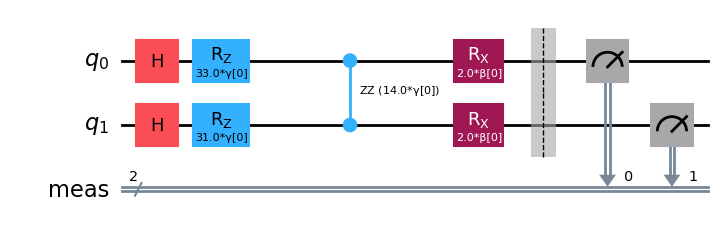

In [9]:
circuit = create_circuit(hamiltonian, 1, 3, backend)

circuit.draw(output="mpl", style="iqp")

In [10]:
results = run_experiment(30, 2, 2, 5000, 5000, 3, hamiltonian)

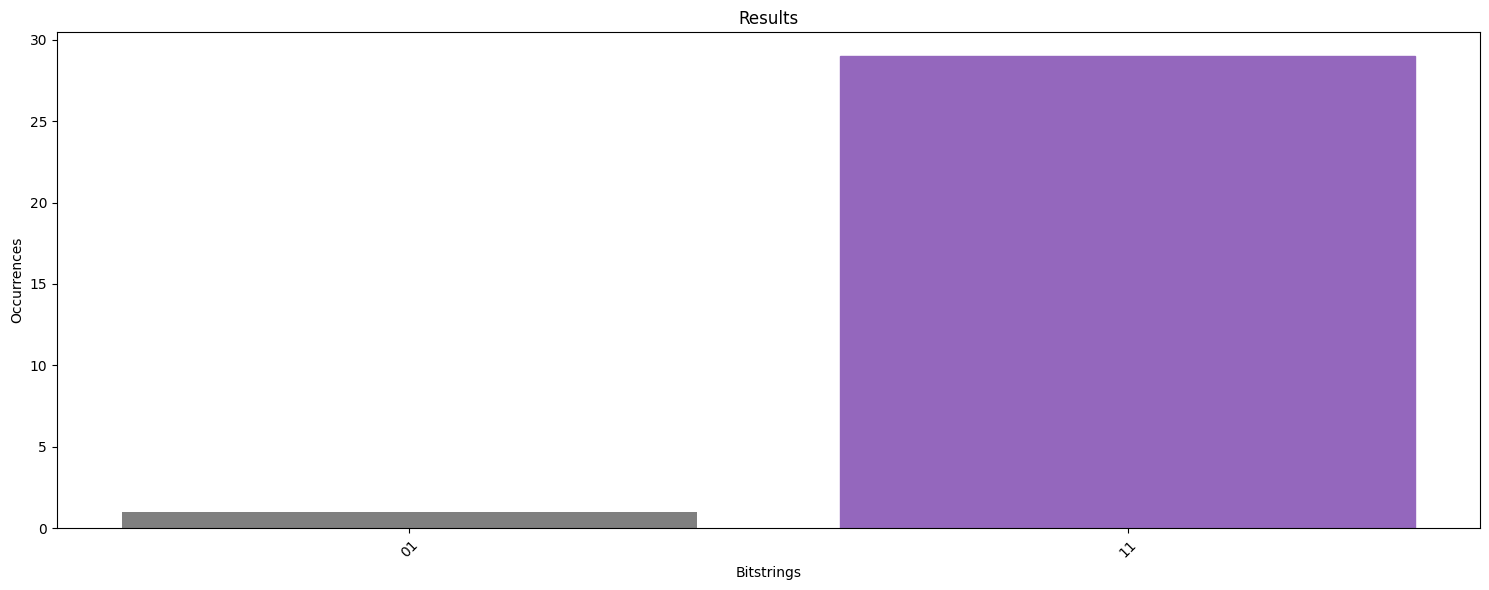

In [11]:
plot_graph_bitstrings_results(results)